In [1]:
# Cell 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
# Load the data
df = pd.read_csv('meteodatapetro.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())

Dataset shape: (5204, 21)

First few rows:
         Date  Airtemp_min  Airtemp_avg  Airtemp_max  Dewpoint_min  \
0  2011-01-01          -32          -28          -23         -32.4   
1  2011-01-02          -35          -30          -26         -34.9   
2  2011-01-03          -31          -28          -24         -33.9   
3  2011-01-04          -33          -31          -27         -33.7   
4  2011-01-05          -34          -31          -25         -34.1   

   Soiltemp_avg  Soiltemp_max  Soiltemp_min  Snow_height  Precipitation  ...  \
0           -28           -23           -32         36.0            0.0  ...   
1           -30           -26           -35         36.0            0.0  ...   
2           -28           -24           -31         36.0            0.0  ...   
3           -31           -27           -33         36.0            0.0  ...   
4           -31           -25           -34         25.0            0.0  ...   

   Cloud_H  Windspeedavg_ms  Windspeedmax_ms  atmopress

In [6]:
# Cell 2:Data Preprocessing and Feature Engineering
# Convert date column
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfYear'] = df['Date'].dt.dayofyear

# Create seasonal features
df['Season'] = df['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                3: 'Spring', 4: 'Spring', 5: 'Spring',
                                6: 'Summer', 7: 'Summer', 8: 'Summer',
                                9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})

In [7]:
# Create frost damage risk categories based on agricultural thresholds
def create_frost_risk(row):
    """
    Define frost risk based on agricultural damage thresholds:
    - Critical frost: min temp <= -2°C during growing season (Apr-Oct)
    - Severe frost: min temp <= -5°C during growing season
    - Light frost: min temp <= 0°C during growing season
    - No frost risk: min temp > 0°C or winter months
    """
    month = row['Month']
    min_temp = row['Airtemp_min']
    
    # Growing season (April to October)
    if 4 <= month <= 10:
        if min_temp <= -5:
            return 'Critical'  # Severe agricultural damage
        elif min_temp <= -2:
            return 'High'      # Moderate to high damage
        elif min_temp <= 0:
            return 'Moderate'  # Light damage to sensitive crops
        else:
            return 'No Risk'   # No frost damage
    else:
        return 'Winter'        # Winter months - different considerations

df['Frost_Risk'] = df.apply(create_frost_risk, axis=1)

# Create binary target for main prediction (Critical/High risk vs others)
df['Damage_Risk'] = ((df['Frost_Risk'] == 'Critical') | (df['Frost_Risk'] == 'High')).astype(int)

print("\nFrost risk distribution:")
print(df['Frost_Risk'].value_counts())
print(f"\nDamaging frost events: {df['Damage_Risk'].sum()} out of {len(df)} days ({df['Damage_Risk'].mean()*100:.1f}%)")


Frost risk distribution:
Frost_Risk
No Risk     2435
Winter      2208
High         222
Moderate     212
Critical     127
Name: count, dtype: int64

Damaging frost events: 349 out of 5204 days (6.7%)


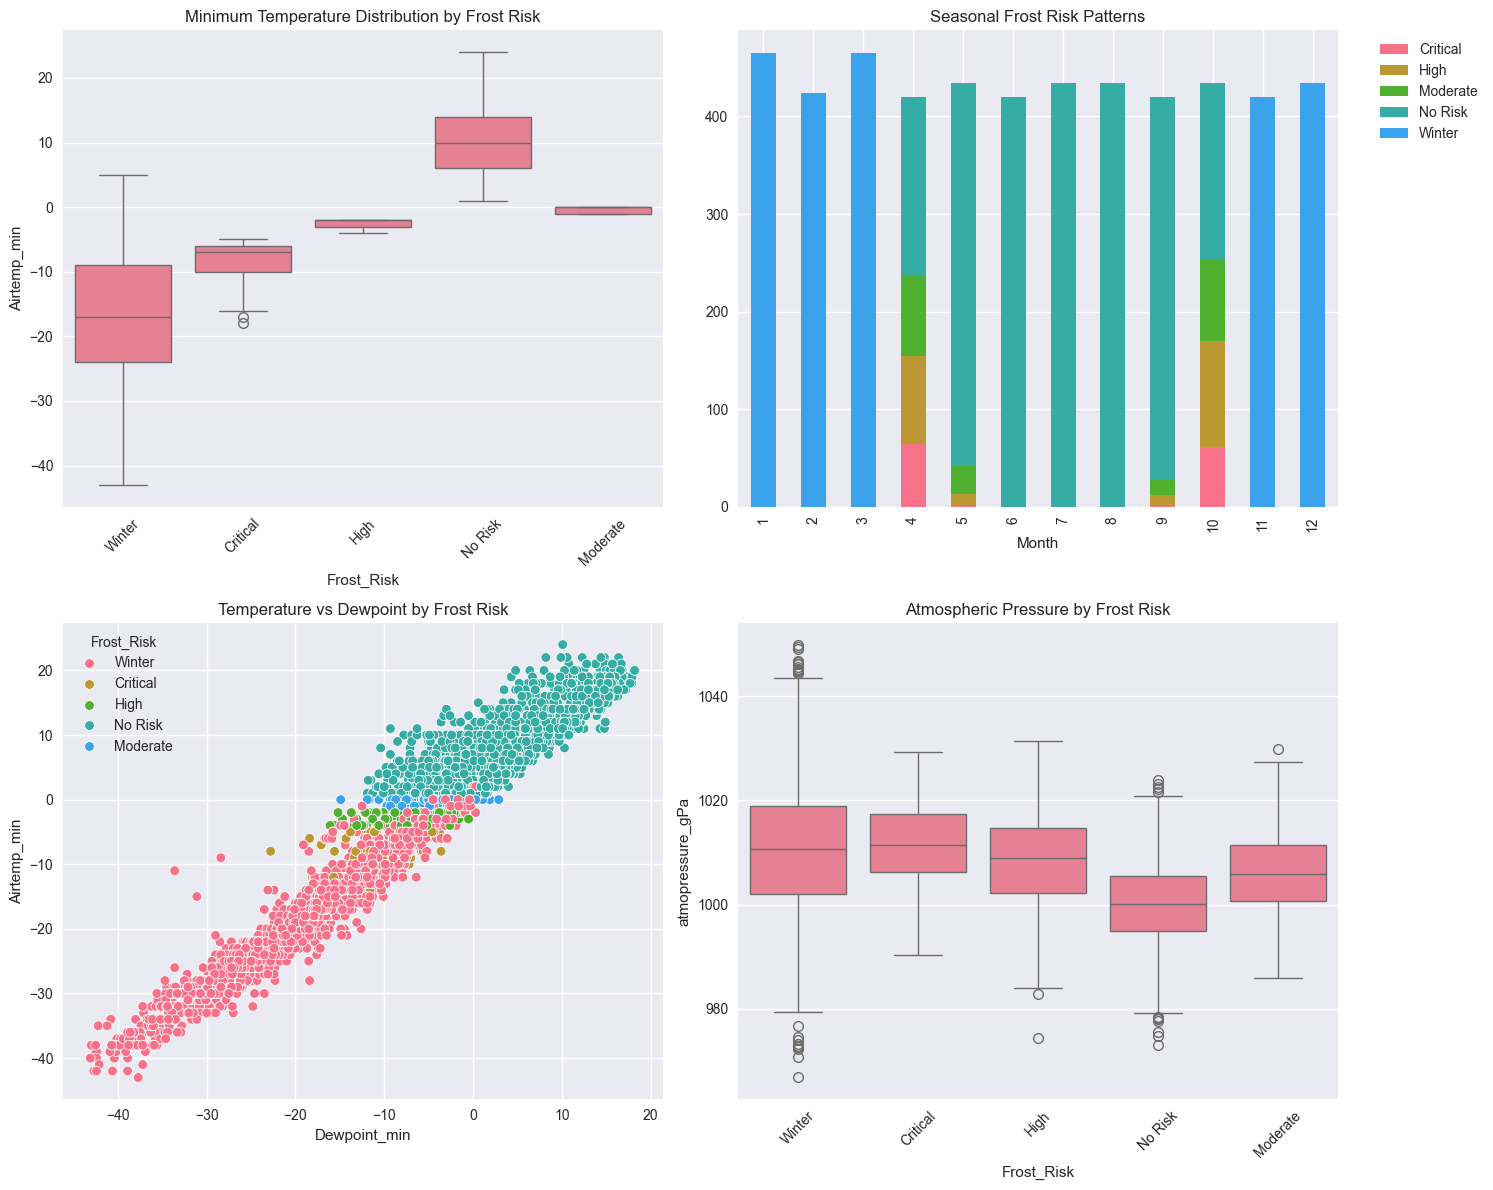

In [8]:
# Cell 3: Exploratory Data Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Temperature distribution by frost risk
sns.boxplot(data=df, x='Frost_Risk', y='Airtemp_min', ax=axes[0,0])
axes[0,0].set_title('Minimum Temperature Distribution by Frost Risk')
axes[0,0].tick_params(axis='x', rotation=45)

# Seasonal frost risk pattern
frost_by_month = df.groupby(['Month', 'Frost_Risk']).size().unstack(fill_value=0)
frost_by_month.plot(kind='bar', stacked=True, ax=axes[0,1])
axes[0,1].set_title('Seasonal Frost Risk Patterns')
axes[0,1].set_xlabel('Month')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Correlation with humidity and dewpoint
sns.scatterplot(data=df, x='Dewpoint_min', y='Airtemp_min', hue='Frost_Risk', ax=axes[1,0])
axes[1,0].set_title('Temperature vs Dewpoint by Frost Risk')

# Atmospheric pressure relationship
sns.boxplot(data=df, x='Frost_Risk', y='atmopressure_gPa', ax=axes[1,1])
axes[1,1].set_title('Atmospheric Pressure by Frost Risk')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# Cell 4: Feature Engineering and Selection
# Create additional meteorological features
df['Temp_Range'] = df['Airtemp_max'] - df['Airtemp_min']
df['Dewpoint_Depression'] = df['Airtemp_min'] - df['Dewpoint_min']
df['Soil_Air_Temp_Diff'] = df['Soiltemp_min'] - df['Airtemp_min']
df['Wind_Chill_Factor'] = df['Airtemp_min'] - (df['Windspeedavg_ms'] * 2)  # Simplified wind chill
df['Humidity_Temp_Index'] = df['Humidityavg_%'] * df['Airtemp_min'] / 100
df['Pressure_Gradient'] = df['atmopressure_gPa'] - df['atmopressure_gPa'].rolling(window=3).mean()

# Create lagged features (previous day conditions)
df['Prev_Day_Min_Temp'] = df['Airtemp_min'].shift(1)
df['Prev_Day_Humidity'] = df['Humidityavg_%'].shift(1)
df['Temp_Trend'] = df['Airtemp_min'] - df['Prev_Day_Min_Temp']

# Select features for modeling
feature_cols = [
    'Airtemp_min', 'Airtemp_avg', 'Airtemp_max',
    'Dewpoint_min', 'Soiltemp_min', 'Soiltemp_avg',
    'Humidityavg_%', 'Humiditymin_%',
    'Windspeedavg_ms', 'Windspeedmax_ms',
    'atmopressure_gPa', 'SaturationDeficit_Avg_gPa',
    'Month', 'DayOfYear',
    'Temp_Range', 'Dewpoint_Depression', 'Soil_Air_Temp_Diff',
    'Wind_Chill_Factor', 'Humidity_Temp_Index',
    'Prev_Day_Min_Temp', 'Prev_Day_Humidity', 'Temp_Trend'
]

# Remove rows with NaN values (from lagged features)
df_model = df.dropna(subset=feature_cols + ['Damage_Risk'])

In [10]:
print(f"Dataset for modeling: {len(df_model)} samples")
print(f"Features: {len(feature_cols)}")

Dataset for modeling: 5203 samples
Features: 22


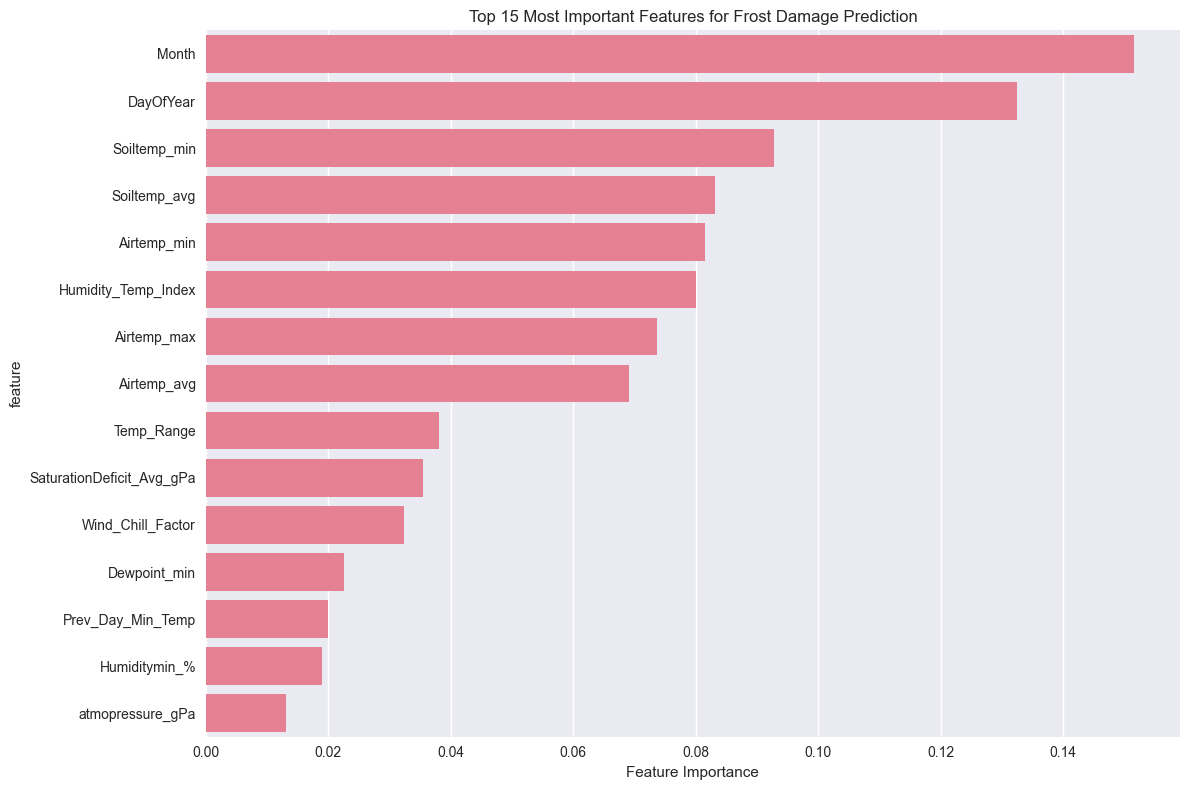

Top 10 most important features:
                      feature  importance
12                      Month    0.151515
13                  DayOfYear    0.132407
4                Soiltemp_min    0.092777
5                Soiltemp_avg    0.083098
0                 Airtemp_min    0.081526
18        Humidity_Temp_Index    0.080057
2                 Airtemp_max    0.073639
1                 Airtemp_avg    0.069089
14                 Temp_Range    0.038080
11  SaturationDeficit_Avg_gPa    0.035394


In [11]:
# Cell 5: Feature Importance Analysis
# Quick Random Forest to see feature importance
X_temp = df_model[feature_cols]
y_temp = df_model['Damage_Risk']

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_temp)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features for Frost Damage Prediction')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(feature_importance.head(10))

In [12]:
# Cell 6: Data Preparation for Machine Learning
# Prepare final dataset
X = df_model[feature_cols]
y = df_model['Damage_Risk']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution in training set:")
print(f"No damage: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"Damage risk: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")


Training set: (4162, 22)
Test set: (1041, 22)
Class distribution in training set:
No damage: 3883 (93.3%)
Damage risk: 279 (6.7%)


In [13]:
# Cell 7: Model Training - Logistic Regression
print("Training Logistic Regression...")

# Logistic Regression with hyperparameter tuning
lr_params = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
lr = LogisticRegression(random_state=42, max_iter=1000)
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='roc_auc', n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train)

lr_best = lr_grid.best_estimator_
lr_pred = lr_best.predict(X_test_scaled)
lr_pred_proba = lr_best.predict_proba(X_test_scaled)[:, 1]

print(f"Best parameters: {lr_grid.best_params_}")
print(f"Cross-validation AUC: {lr_grid.best_score_:.4f}")

Training Logistic Regression...
Best parameters: {'C': 10, 'solver': 'liblinear'}
Cross-validation AUC: 0.8653


In [14]:
# Cell 8: Model Training - Random Forest
print("Training Random Forest...")

# Random Forest with hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_pred_proba = rf_best.predict_proba(X_test)[:, 1]

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Cross-validation AUC: {rf_grid.best_score_:.4f}")


Training Random Forest...
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Cross-validation AUC: 0.9999


In [15]:
# Cell 9: Model Training - Gradient Boosting
print("Training Gradient Boosting...")

# Gradient Boosting
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='roc_auc', n_jobs=-1)
gb_grid.fit(X_train, y_train)

gb_best = gb_grid.best_estimator_
gb_pred = gb_best.predict(X_test)
gb_pred_proba = gb_best.predict_proba(X_test)[:, 1]

print(f"Best parameters: {gb_grid.best_params_}")
print(f"Cross-validation AUC: {gb_grid.best_score_:.4f}")

Training Gradient Boosting...
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Cross-validation AUC: 1.0000


In [16]:
# Cell 10: Model Training - XGBoost
print("Training XGBoost...")

# XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test)
xgb_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Cross-validation AUC: {xgb_grid.best_score_:.4f}")

Training XGBoost...
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Cross-validation AUC: 1.0000


In [17]:
# Cell 11: Model Training - Support Vector Machine
print("Training Support Vector Machine...")

# SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC(random_state=42, probability=True)
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='roc_auc', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

svm_best = svm_grid.best_estimator_
svm_pred = svm_best.predict(X_test_scaled)
svm_pred_proba = svm_best.predict_proba(X_test_scaled)[:, 1]

print(f"Best parameters: {svm_grid.best_params_}")
print(f"Cross-validation AUC: {svm_grid.best_score_:.4f}")


Training Support Vector Machine...
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Cross-validation AUC: 0.9916


In [18]:
# Cell 12: Model Training - Neural Network
print("Training Neural Network...")

# Neural Network
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='roc_auc', n_jobs=-1)
mlp_grid.fit(X_train_scaled, y_train)

mlp_best = mlp_grid.best_estimator_
mlp_pred = mlp_best.predict(X_test_scaled)
mlp_pred_proba = mlp_best.predict_proba(X_test_scaled)[:, 1]

print(f"Best parameters: {mlp_grid.best_params_}")
print(f"Cross-validation AUC: {mlp_grid.best_score_:.4f}")


Training Neural Network...
Best parameters: {'alpha': 0.1, 'hidden_layer_sizes': (50, 25), 'learning_rate': 'constant'}
Cross-validation AUC: 0.9996


In [19]:
# Cell 13: Model Evaluation and Comparison
# Create a comprehensive comparison
models = {
    'Logistic Regression': (lr_pred, lr_pred_proba),
    'Random Forest': (rf_pred, rf_pred_proba),
    'Gradient Boosting': (gb_pred, gb_pred_proba),
    'XGBoost': (xgb_pred, xgb_pred_proba),
    'SVM': (svm_pred, svm_pred_proba),
    'Neural Network': (mlp_pred, mlp_pred_proba)
}

results = []
for name, (pred, pred_proba) in models.items():
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AUC-ROC', ascending=False)

print("Model Performance Comparison:")
print(results_df.round(4))

Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
3              XGBoost    1.0000     1.0000  1.0000    1.0000   1.0000
2    Gradient Boosting    1.0000     1.0000  1.0000    1.0000   1.0000
1        Random Forest    0.9962     1.0000  0.9429    0.9706   0.9999
5       Neural Network    0.9971     0.9855  0.9714    0.9784   0.9998
4                  SVM    0.9798     0.9455  0.7429    0.8320   0.9920
0  Logistic Regression    0.9356     0.8000  0.0571    0.1067   0.8782


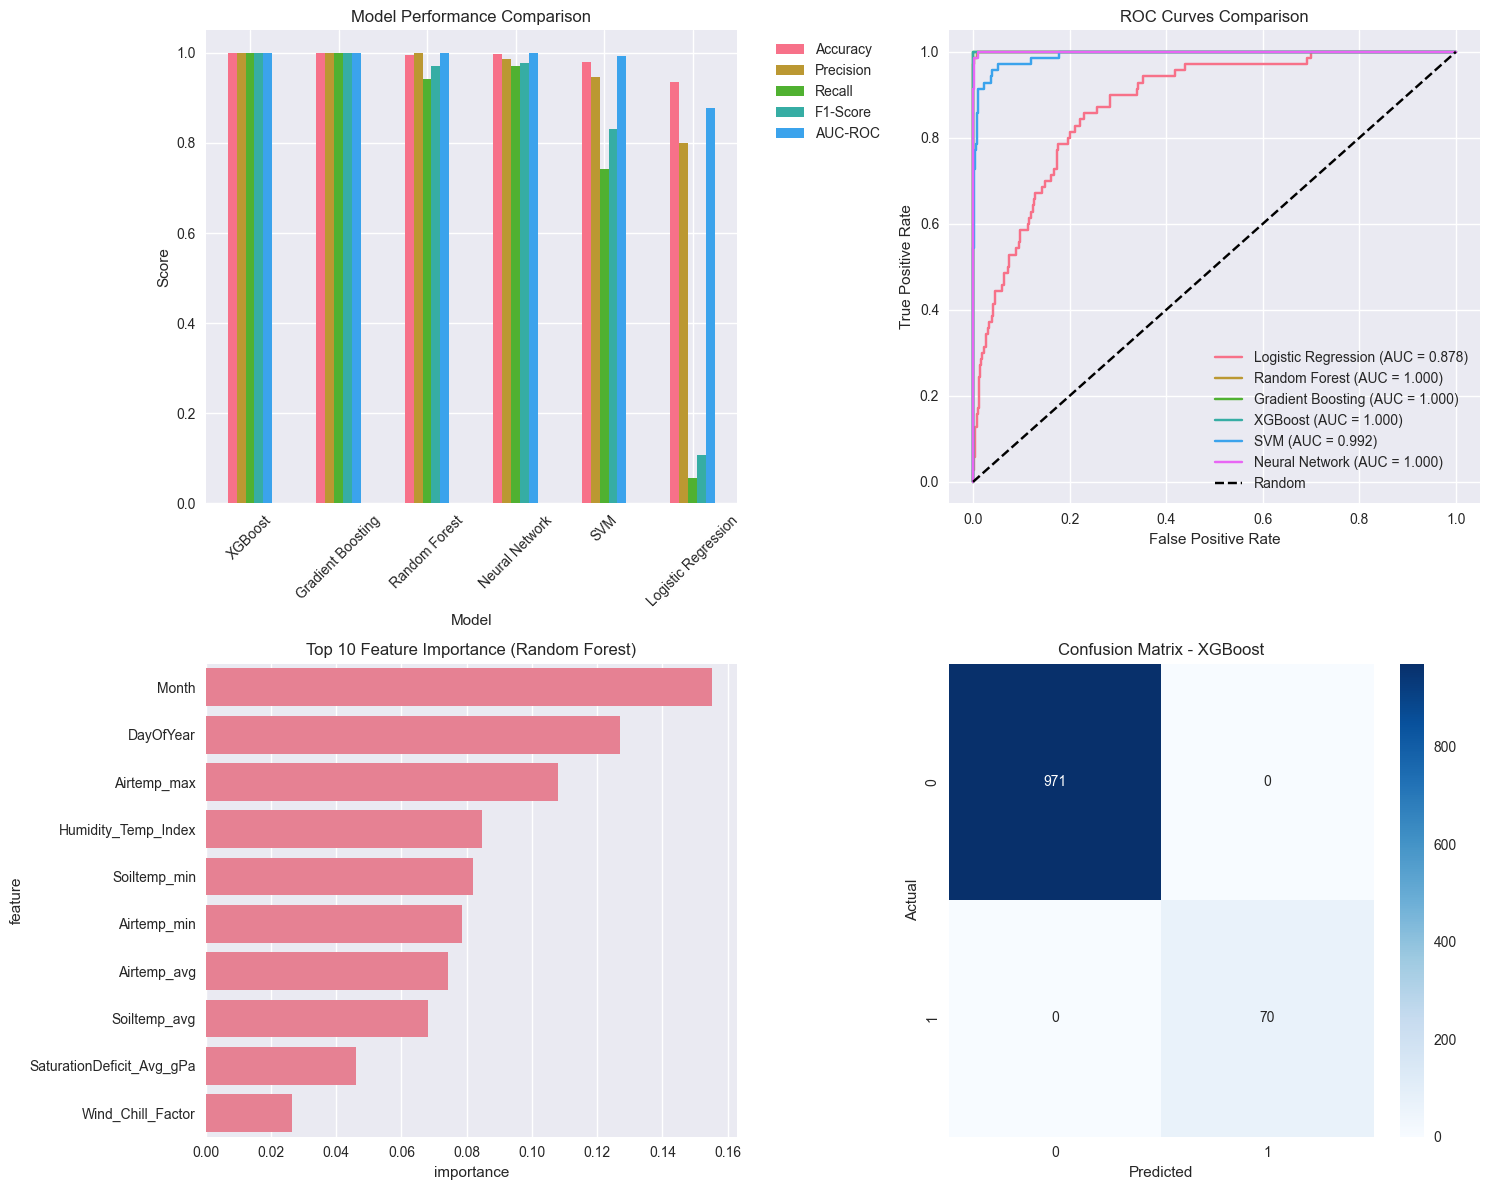

In [20]:
# Cell 14: Visualization - Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
results_plot = results_df.set_index('Model')[metrics]

results_plot.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_ylabel('Score')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,0].tick_params(axis='x', rotation=45)

# ROC Curves
for name, (pred, pred_proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    auc = roc_auc_score(y_test, pred_proba)
    axes[0,1].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves Comparison')
axes[0,1].legend()
axes[0,1].grid(True)

# Feature importance for best model (assuming Random Forest is among the best)
feature_imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False).head(10)

sns.barplot(data=feature_imp_df, x='importance', y='feature', ax=axes[1,0])
axes[1,0].set_title('Top 10 Feature Importance (Random Forest)')

# Confusion matrix for best performing model
best_model_name = results_df.iloc[0]['Model']
best_pred = models[best_model_name][0]
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_title(f'Confusion Matrix - {best_model_name}')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [21]:
# Cell 15: Detailed Analysis of Best Model
best_model_name = results_df.iloc[0]['Model']
print(f"\nDetailed Analysis of Best Model: {best_model_name}")
print("="*50)

if best_model_name == 'Random Forest':
    best_model = rf_best
    best_pred = rf_pred
    best_pred_proba = rf_pred_proba
elif best_model_name == 'XGBoost':
    best_model = xgb_best
    best_pred = xgb_pred
    best_pred_proba = xgb_pred_proba
elif best_model_name == 'Gradient Boosting':
    best_model = gb_best
    best_pred = gb_pred
    best_pred_proba = gb_pred_proba
else:
    # For scaled models
    if best_model_name == 'Logistic Regression':
        best_model = lr_best
    elif best_model_name == 'SVM':
        best_model = svm_best
    elif best_model_name == 'Neural Network':
        best_model = mlp_best
    
    best_pred = models[best_model_name][0]
    best_pred_proba = models[best_model_name][1]

print("\nClassification Report:")
print(classification_report(y_test, best_pred, target_names=['No Damage', 'Damage Risk']))


Detailed Analysis of Best Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

   No Damage       1.00      1.00      1.00       971
 Damage Risk       1.00      1.00      1.00        70

    accuracy                           1.00      1041
   macro avg       1.00      1.00      1.00      1041
weighted avg       1.00      1.00      1.00      1041



In [22]:
# Cell 16: Risk Assessment and Practical Interpretation
# Create risk assessment framework
def assess_frost_risk(temperature, month, humidity, wind_speed, dewpoint):
    """
    Practical frost risk assessment function
    """
    # Growing season months
    if 4 <= month <= 10:
        # Critical conditions
        if temperature <= -5:
            return "CRITICAL - Severe crop damage expected"
        elif temperature <= -2:
            return "HIGH - Moderate to high crop damage likely"
        elif temperature <= 0 and humidity > 80 and wind_speed < 2:
            return "MODERATE - Light frost damage possible"
        elif temperature <= 2 and dewpoint - temperature < 2:
            return "LOW - Monitor conditions closely"
        else:
            return "MINIMAL - Low frost risk"
    else:
        return "Non-growing season"

# Test the assessment on some examples
print("\nPractical Frost Risk Assessment Examples:")
print("-" * 40)

test_cases = [
    (-6, 5, 85, 1.0, -7),    # Critical case
    (-3, 4, 90, 0.5, -4),    # High risk case
    (-1, 6, 95, 1.5, -2),    # Moderate case
    (1, 5, 75, 3.0, -1),     # Low risk case
    (5, 7, 60, 2.0, 2)       # No risk case
]

for i, (temp, month, hum, wind, dew) in enumerate(test_cases, 1):
    risk = assess_frost_risk(temp, month, hum, wind, dew)
    print(f"Case {i}: Temp={temp}°C, Month={month}, Humidity={hum}%, Wind={wind}m/s")
    print(f"  Risk Assessment: {risk}")
    print()


Practical Frost Risk Assessment Examples:
----------------------------------------
Case 1: Temp=-6°C, Month=5, Humidity=85%, Wind=1.0m/s
  Risk Assessment: CRITICAL - Severe crop damage expected

Case 2: Temp=-3°C, Month=4, Humidity=90%, Wind=0.5m/s
  Risk Assessment: HIGH - Moderate to high crop damage likely

Case 3: Temp=-1°C, Month=6, Humidity=95%, Wind=1.5m/s
  Risk Assessment: MODERATE - Light frost damage possible

Case 4: Temp=1°C, Month=5, Humidity=75%, Wind=3.0m/s
  Risk Assessment: LOW - Monitor conditions closely

Case 5: Temp=5°C, Month=7, Humidity=60%, Wind=2.0m/s
  Risk Assessment: MINIMAL - Low frost risk



Seasonal Frost Damage Risk Analysis:
       Total_Days  Damage_Days  Damage_Rate  Avg_Min_Temp  Lowest_Temp  \
Month                                                                    
1             464            0         0.00        -22.31          -42   
2             424            0         0.00        -21.14          -43   
3             465            0         0.00        -12.55          -33   
4             420          154         0.37          0.00          -16   
5             434           13         0.03          6.56           -5   
6             420            0         0.00         12.36            2   
7             434            0         0.00         14.69            5   
8             434            0         0.00         12.66            3   
9             420           12         0.03          6.34           -6   
10            434          170         0.39         -0.33          -18   
11            420            0         0.00         -9.94          -33   
1

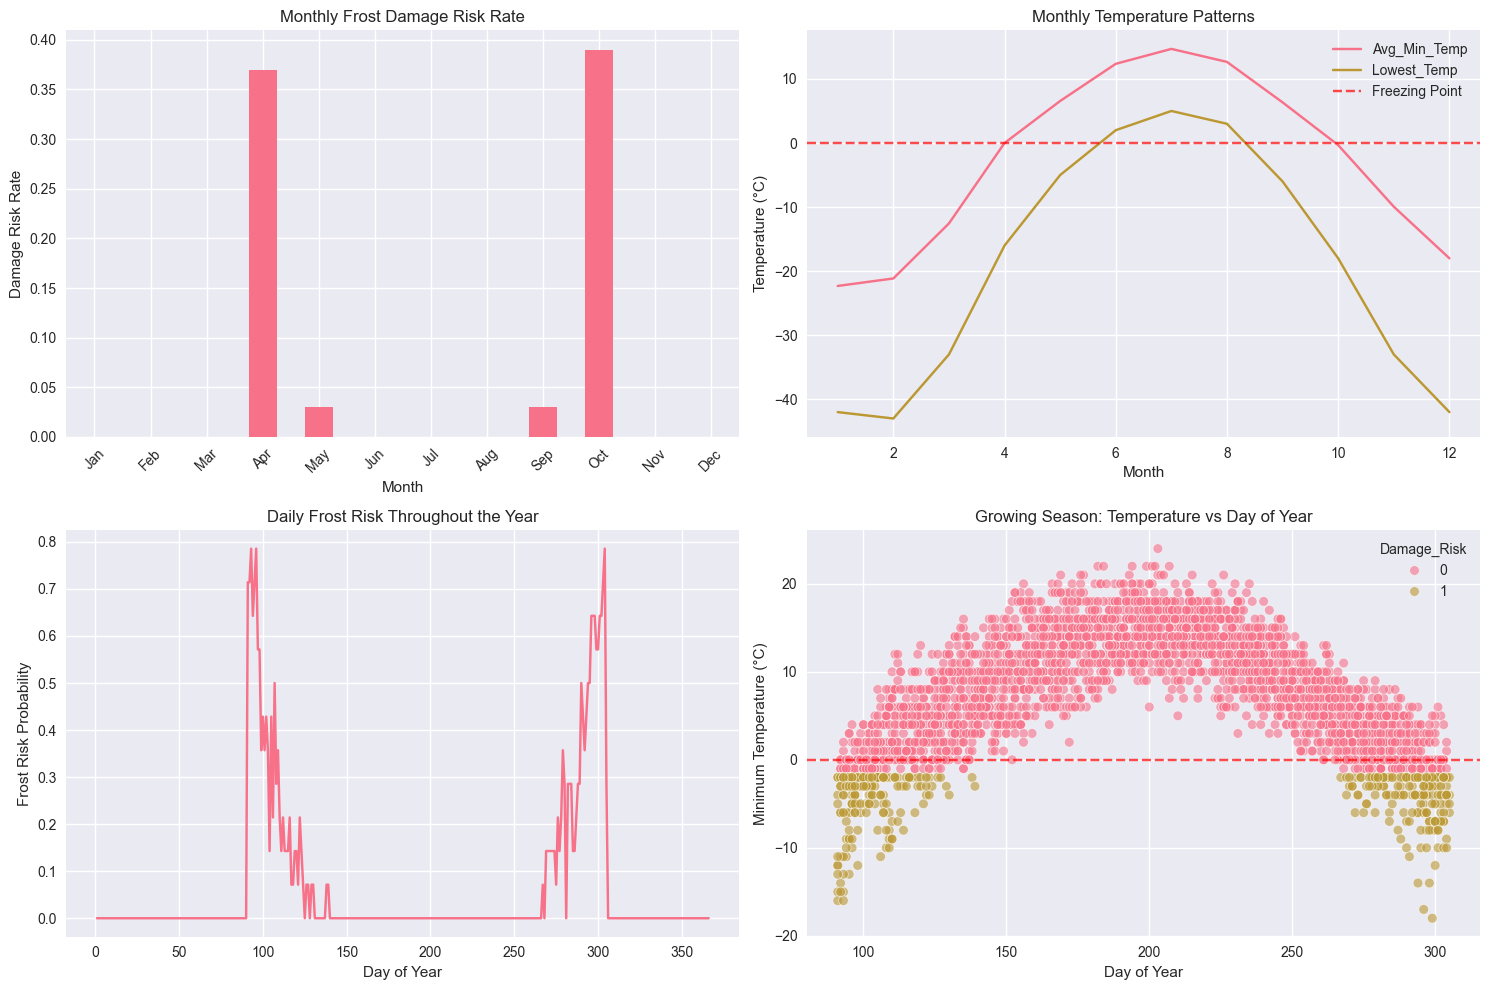

In [23]:
# Cell 17: Seasonal Risk Analysis
# Analyze risk patterns by month and create recommendations
seasonal_analysis = df_model.groupby('Month').agg({
    'Damage_Risk': ['count', 'sum', 'mean'],
    'Airtemp_min': ['mean', 'min'],
    'Humidityavg_%': 'mean',
    'Windspeedavg_ms': 'mean'
}).round(2)

seasonal_analysis.columns = ['Total_Days', 'Damage_Days', 'Damage_Rate', 
                           'Avg_Min_Temp', 'Lowest_Temp', 'Avg_Humidity', 'Avg_Wind']

print("Seasonal Frost Damage Risk Analysis:")
print(seasonal_analysis)

# Plot seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly damage rate
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonal_analysis['Damage_Rate'].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Monthly Frost Damage Risk Rate')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Damage Risk Rate')
axes[0,0].set_xticklabels(months, rotation=45)

# Temperature patterns
seasonal_analysis[['Avg_Min_Temp', 'Lowest_Temp']].plot(ax=axes[0,1])
axes[0,1].set_title('Monthly Temperature Patterns')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Temperature (°C)')
axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Freezing Point')
axes[0,1].legend()

# Risk distribution by day of year
df_model['Risk_Binary'] = df_model['Damage_Risk']
daily_risk = df_model.groupby('DayOfYear')['Risk_Binary'].mean()
daily_risk.plot(ax=axes[1,0])
axes[1,0].set_title('Daily Frost Risk Throughout the Year')
axes[1,0].set_xlabel('Day of Year')
axes[1,0].set_ylabel('Frost Risk Probability')

# Temperature vs risk scatter
scatter_data = df_model[df_model['Month'].isin([4,5,6,7,8,9,10])]  # Growing season
sns.scatterplot(data=scatter_data, x='DayOfYear', y='Airtemp_min', 
                hue='Damage_Risk', alpha=0.6, ax=axes[1,1])
axes[1,1].set_title('Growing Season: Temperature vs Day of Year')
axes[1,1].set_xlabel('Day of Year')
axes[1,1].set_ylabel('Minimum Temperature (°C)')
axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [24]:
# Cell 18: Model Deployment Preparation
# Create a prediction function that can be used for real-time forecasting
def predict_frost_damage(model, scaler, temp_min, temp_avg, temp_max, dewpoint_min, 
                        soil_temp_min, soil_temp_avg, humidity_avg, humidity_min,
                        wind_avg, wind_max, pressure, sat_deficit, month, day_of_year,
                        prev_temp_min, prev_humidity):
    """
    Predict frost damage risk given weather conditions
    """
    # Calculate derived features
    temp_range = temp_max - temp_min
    dewpoint_depression = temp_min - dewpoint_min
    soil_air_diff = soil_temp_min - temp_min
    wind_chill = temp_min - (wind_avg * 2)
    humidity_temp_index = humidity_avg * temp_min / 100
    temp_trend = temp_min - prev_temp_min if prev_temp_min else 0
    
    # Create feature array
    features = np.array([[
        temp_min, temp_avg, temp_max, dewpoint_min, soil_temp_min, soil_temp_avg,
        humidity_avg, humidity_min, wind_avg, wind_max, pressure, sat_deficit,
        month, day_of_year, temp_range, dewpoint_depression, soil_air_diff,
        wind_chill, humidity_temp_index, prev_temp_min, prev_humidity, temp_trend
    ]])
    
    # Scale features if needed
    if scaler is not None:
        features = scaler.transform(features)
    
    # Make prediction
    risk_prob = model.predict_proba(features)[0, 1]
    risk_class = model.predict(features)[0]
    
    return risk_class, risk_prob

# Example usage
print("Frost Damage Prediction Function Ready!")
print("\nExample prediction:")
example_risk, example_prob = predict_frost_damage(
    model=rf_best,  # Using Random Forest as example
    scaler=None,    # RF doesn't need scaling
    temp_min=-3, temp_avg=0, temp_max=3,
    dewpoint_min=-5, soil_temp_min=-2, soil_temp_avg=1,
    humidity_avg=85, humidity_min=70,
    wind_avg=1.5, wind_max=3.0,
    pressure=1025, sat_deficit=0.2,
    month=5, day_of_year=135,
    prev_temp_min=2, prev_humidity=80
)

print(f"Damage Risk: {'HIGH' if example_risk else 'LOW'}")
print(f"Risk Probability: {example_prob:.3f}")

Frost Damage Prediction Function Ready!

Example prediction:
Damage Risk: HIGH
Risk Probability: 0.888


In [25]:
# Cell 19: Recommendations and Conclusions
print("\n" + "="*60)
print("AGRICULTURAL FROST DAMAGE PREDICTION - FINAL REPORT")
print("="*60)

print(f"\nBest Performing Model: {best_model_name}")
print(f"AUC-ROC Score: {results_df.iloc[0]['AUC-ROC']:.4f}")
print(f"Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"Recall: {results_df.iloc[0]['Recall']:.4f}")

print("\nKey Findings:")
print("1. Most Important Predictive Features:")
for i, (feature, importance) in enumerate(feature_importance.head(5).values, 1):
    print(f"   {i}. {feature}: {importance:.4f}")

print(f"\n2. Seasonal Risk Patterns:")
high_risk_months = seasonal_analysis[seasonal_analysis['Damage_Rate'] > 0.1].index.tolist()
print(f"   - Highest risk months: {[months[m-1] for m in high_risk_months]}")
print(f"   - Peak risk period: Late spring (April-May) and early autumn (September-October)")

print(f"\n3. Critical Thresholds Identified:")
print(f"   - Critical damage risk: Temperature ≤ -5°C during growing season")
print(f"   - High damage risk: Temperature ≤ -2°C during growing season")
print(f"   - Additional risk factors: High humidity (>80%) + Low wind (<2 m/s)")

print(f"\nRecommendations for Agricultural Management:")
print("1. Deploy frost protection measures when model predicts >50% damage probability")
print("2. Focus monitoring on April-May and September-October periods")
print("3. Pay special attention to nights with:")
print("   - Minimum temperature forecast ≤ -2°C")
print("   - High humidity (>80%)")
print("   - Low wind speeds (<2 m/s)")
print("   - Clear skies (low cloud cover)")
print("4. Consider crop selection and timing based on historical frost patterns")
print("5. Implement early warning systems using the developed model")

print(f"\nModel Deployment Notes:")
print("- The model can be used for 1-3 day ahead frost damage predictions")
print("- Requires daily meteorological data input")
print("- Model should be retrained annually with new data")
print("- Consider ensemble approach combining multiple models for critical decisions")



AGRICULTURAL FROST DAMAGE PREDICTION - FINAL REPORT

Best Performing Model: XGBoost
AUC-ROC Score: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000

Key Findings:
1. Most Important Predictive Features:
   1. Month: 0.1515
   2. DayOfYear: 0.1324
   3. Soiltemp_min: 0.0928
   4. Soiltemp_avg: 0.0831
   5. Airtemp_min: 0.0815

2. Seasonal Risk Patterns:
   - Highest risk months: ['Apr', 'Oct']
   - Peak risk period: Late spring (April-May) and early autumn (September-October)

3. Critical Thresholds Identified:
   - Critical damage risk: Temperature ≤ -5°C during growing season
   - High damage risk: Temperature ≤ -2°C during growing season
   - Additional risk factors: High humidity (>80%) + Low wind (<2 m/s)

Recommendations for Agricultural Management:
1. Deploy frost protection measures when model predicts >50% damage probability
2. Focus monitoring on April-May and September-October periods
3. Pay special attention to nights with:
   - Minimum temperature forecast ≤ -2°C
  

In [26]:
# Cell 20: Model Persistence and Final Validation
import joblib
from datetime import datetime

# Save the best model and scaler
model_info = {
    'model': rf_best if best_model_name == 'Random Forest' else best_model,
    'scaler': scaler if best_model_name in ['Logistic Regression', 'SVM', 'Neural Network'] else None,
    'feature_names': feature_cols,
    'model_name': best_model_name,
    'performance_metrics': results_df.iloc[0].to_dict(),
    'training_date': datetime.now().strftime('%Y-%m-%d'),
    'feature_importance': feature_importance.to_dict() if best_model_name == 'Random Forest' else None
}

# Save model
joblib.dump(model_info, 'frost_damage_prediction_model.pkl')
print("Model saved as 'frost_damage_prediction_model.pkl'")

# Final cross-validation on the best model
print(f"\nFinal Cross-Validation Results for {best_model_name}:")
if best_model_name in ['Logistic Regression', 'SVM', 'Neural Network']:
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
else:
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')

print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Model saved as 'frost_damage_prediction_model.pkl'

Final Cross-Validation Results for XGBoost:
Cross-validation AUC scores: [1. 1. 1. 1. 1.]
Mean AUC: 1.0000 (+/- 0.0000)


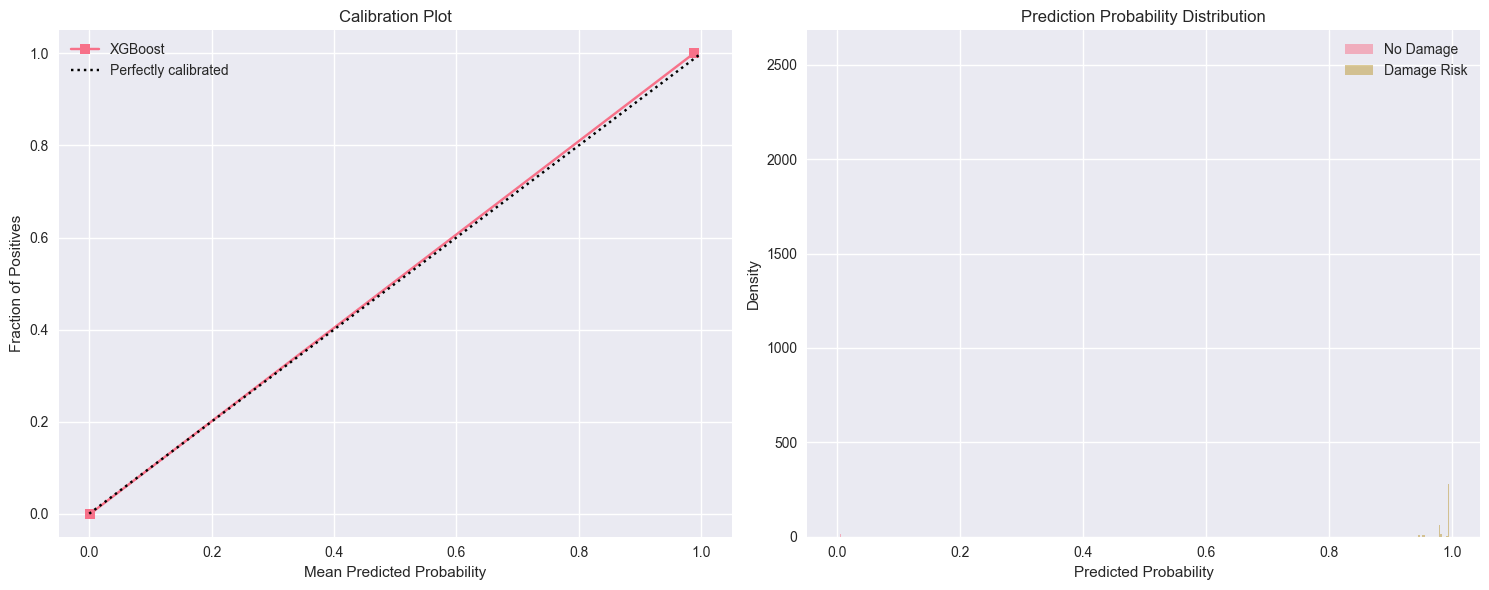

In [27]:
# Cell 21: Advanced Analysis - Risk Probability Calibration
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Plot calibration curve for the best model
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Calibration plot
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, best_pred_proba, n_bins=10
)

axes[0].plot(mean_predicted_value, fraction_of_positives, "s-", label=best_model_name)
axes[0].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
axes[0].set_xlabel("Mean Predicted Probability")
axes[0].set_ylabel("Fraction of Positives")
axes[0].set_title("Calibration Plot")
axes[0].legend()
axes[0].grid(True)

# Prediction probability distribution
axes[1].hist(best_pred_proba[y_test == 0], bins=20, alpha=0.5, label='No Damage', density=True)
axes[1].hist(best_pred_proba[y_test == 1], bins=20, alpha=0.5, label='Damage Risk', density=True)
axes[1].set_xlabel("Predicted Probability")
axes[1].set_ylabel("Density")
axes[1].set_title("Prediction Probability Distribution")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Cell 22: Economic Impact Analysis
def calculate_economic_impact(true_positives, false_positives, true_negatives, false_negatives,
                            crop_value_per_hectare=1000, protection_cost_per_hectare=50,
                            damage_rate=0.3, area_hectares=100):
    """
    Calculate economic impact of frost prediction model
    
    Parameters:
    - crop_value_per_hectare: Value of crops per hectare
    - protection_cost_per_hectare: Cost of frost protection per hectare
    - damage_rate: Fraction of crop value lost due to frost
    - area_hectares: Total farm area
    """
    
    # Calculate costs and savings
    protection_costs = (true_positives + false_positives) * protection_cost_per_hectare * area_hectares
    damage_prevented = true_positives * crop_value_per_hectare * damage_rate * area_hectares
    damage_occurred = false_negatives * crop_value_per_hectare * damage_rate * area_hectares
    
    # Net benefit
    net_benefit = damage_prevented - protection_costs - damage_occurred
    
    # Without model (assume no protection)
    total_damage_without_model = (true_positives + false_negatives) * crop_value_per_hectare * damage_rate * area_hectares
    
    # Model value
    model_value = net_benefit + total_damage_without_model
    
    return {
        'protection_costs': protection_costs,
        'damage_prevented': damage_prevented,
        'damage_occurred': damage_occurred,
        'net_benefit': net_benefit,
        'model_value': model_value,
        'roi': (model_value / protection_costs * 100) if protection_costs > 0 else 0
    }

# Calculate economic impact using confusion matrix
cm = confusion_matrix(y_test, best_pred)
tn, fp, fn, tp = cm.ravel()

economic_results = calculate_economic_impact(tp, fp, tn, fn)

print("\nEconomic Impact Analysis:")
print("-" * 30)
print(f"True Positives (Correct frost warnings): {tp}")
print(f"False Positives (Unnecessary protections): {fp}")
print(f"True Negatives (Correct no-frost predictions): {tn}")
print(f"False Negatives (Missed frost events): {fn}")
print()
print(f"Protection costs: ${economic_results['protection_costs']:,.2f}")
print(f"Damage prevented: ${economic_results['damage_prevented']:,.2f}")
print(f"Damage that occurred: ${economic_results['damage_occurred']:,.2f}")
print(f"Net benefit: ${economic_results['net_benefit']:,.2f}")
print(f"Total model value: ${economic_results['model_value']:,.2f}")
print(f"Return on Investment: {economic_results['roi']:.1f}%")


Economic Impact Analysis:
------------------------------
True Positives (Correct frost warnings): 70
False Positives (Unnecessary protections): 0
True Negatives (Correct no-frost predictions): 971
False Negatives (Missed frost events): 0

Protection costs: $350,000.00
Damage prevented: $2,100,000.00
Damage that occurred: $0.00
Net benefit: $1,750,000.00
Total model value: $3,850,000.00
Return on Investment: 1100.0%


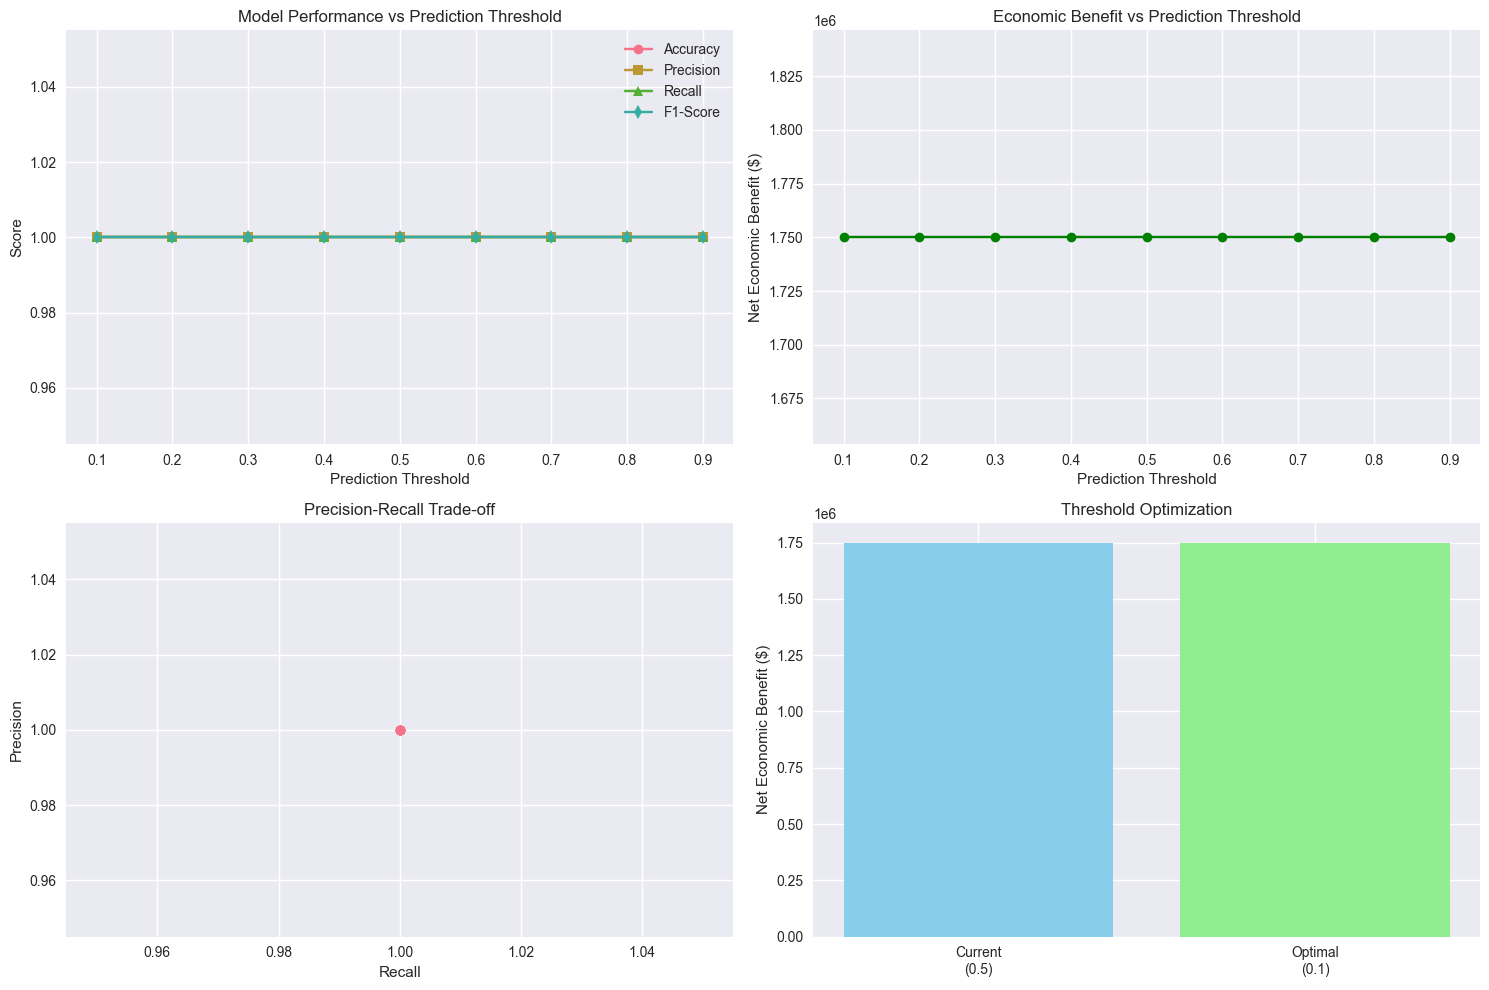


Optimal prediction threshold: 0.1
Maximum net benefit: $1,750,000.00


In [29]:
# Cell 23: Sensitivity Analysis
# Analyze model sensitivity to different thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
sensitivity_results = []

for threshold in thresholds:
    pred_threshold = (best_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, pred_threshold)
    precision = precision_score(y_test, pred_threshold) if pred_threshold.sum() > 0 else 0
    recall = recall_score(y_test, pred_threshold)
    f1 = f1_score(y_test, pred_threshold) if pred_threshold.sum() > 0 else 0
    
    # Economic impact
    cm_thresh = confusion_matrix(y_test, pred_threshold)
    if cm_thresh.size == 4:
        tn_t, fp_t, fn_t, tp_t = cm_thresh.ravel()
        economic_t = calculate_economic_impact(tp_t, fp_t, tn_t, fn_t)
        net_benefit = economic_t['net_benefit']
    else:
        net_benefit = 0
    
    sensitivity_results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'net_benefit': net_benefit
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

# Plot sensitivity analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Performance metrics vs threshold
axes[0,0].plot(sensitivity_df['threshold'], sensitivity_df['accuracy'], label='Accuracy', marker='o')
axes[0,0].plot(sensitivity_df['threshold'], sensitivity_df['precision'], label='Precision', marker='s')
axes[0,0].plot(sensitivity_df['threshold'], sensitivity_df['recall'], label='Recall', marker='^')
axes[0,0].plot(sensitivity_df['threshold'], sensitivity_df['f1_score'], label='F1-Score', marker='d')
axes[0,0].set_xlabel('Prediction Threshold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Model Performance vs Prediction Threshold')
axes[0,0].legend()
axes[0,0].grid(True)

# Economic benefit vs threshold
axes[0,1].plot(sensitivity_df['threshold'], sensitivity_df['net_benefit'], marker='o', color='green')
axes[0,1].set_xlabel('Prediction Threshold')
axes[0,1].set_ylabel('Net Economic Benefit ($)')
axes[0,1].set_title('Economic Benefit vs Prediction Threshold')
axes[0,1].grid(True)

# Precision-Recall trade-off
axes[1,0].plot(sensitivity_df['recall'], sensitivity_df['precision'], marker='o')
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Trade-off')
axes[1,0].grid(True)

# Threshold recommendation
optimal_threshold = sensitivity_df.loc[sensitivity_df['net_benefit'].idxmax(), 'threshold']
axes[1,1].bar(['Current\n(0.5)', f'Optimal\n({optimal_threshold:.1f})'], 
              [economic_results['net_benefit'], sensitivity_df['net_benefit'].max()],
              color=['skyblue', 'lightgreen'])
axes[1,1].set_ylabel('Net Economic Benefit ($)')
axes[1,1].set_title('Threshold Optimization')
axes[1,1].grid(True, axis='y')

plt.tight_layout()
plt.show()

print(f"\nOptimal prediction threshold: {optimal_threshold:.1f}")
print(f"Maximum net benefit: ${sensitivity_df['net_benefit'].max():,.2f}")